In [1]:
import numpy as np
import pandas as pd
from example_models import get_linear_chain_2v
from matplotlib import pyplot as plt

import modelbase2 as mb2
from modelbase2 import Simulator, mc, mca, plot


def make_protocol(steps: dict[float, dict[str, float]]) -> pd.DataFrame:
    data = {}

    t0 = pd.Timedelta(0)
    for step, pars in steps.items():
        t0 += pd.Timedelta(seconds=step)
        data[t0] = pars
    return pd.DataFrame(data).T

Could not find cannot import name 'dopri5' from 'assimulo.lib' (/home/marvin/git/modelbase2b/.pixi/envs/default/lib/python3.12/site-packages/assimulo/lib/__init__.py)
Could not find cannot import name 'rodas' from 'assimulo.lib' (/home/marvin/git/modelbase2b/.pixi/envs/default/lib/python3.12/site-packages/assimulo/lib/__init__.py)
Could not find cannot import name 'odassl' from 'assimulo.lib' (/home/marvin/git/modelbase2b/.pixi/envs/default/lib/python3.12/site-packages/assimulo/lib/__init__.py)
Could not find ODEPACK functions.
Could not find RADAR5
Could not find GLIMDA.


## Simulation

### Steady-state

In [ ]:
concs, fluxes = (
    Simulator(get_linear_chain_2v())  # optionally supply initial conditions
    .simulate_to_steady_state()
    .get_concs_and_fluxes()
)
concs

### Time series

In [ ]:
concs, fluxes = (
    Simulator(get_linear_chain_2v())
    .simulate(t_end=10)  # also possible to set steps or exact time points
    .get_concs_and_fluxes()
)

if concs is not None:
    _ = plot.line(concs)

### Protocol time series

Discrete time changes

In [ ]:
protocol = make_protocol(
    {
        1: {"k1": 1},
        2: {"k1": 2},
        3: {"k1": 1},
    }
)
concs, fluxes = (
    Simulator(
        get_linear_chain_2v(),
    )
    .simulate_over_protocol(protocol)
    .get_concs_and_fluxes()
)

if concs is not None:
    fig, ax = plt.subplots()
    plot.line(concs, ax=ax)
    plot.shade_protocol(protocol["k1"], ax=ax)


## Parameter scans

### Steady-state

In [ ]:
concs, fluxes = mb2.parameter_scan_ss(
    get_linear_chain_2v(),
    {"k1": np.linspace(1, 2, 11)},
)
concs.head()

In [ ]:
concs.plot()

In [ ]:
concs, fluxes = mb2.parameter_scan_ss(
    get_linear_chain_2v(),
    {
        "k1": np.linspace(1, 2, 3),
        "k2": np.linspace(1, 2, 4),
    },
)
concs.head()

In [ ]:
plot.heatmap_from_2d_idx(concs, "x")

In [ ]:
concs, fluxes = mb2.parameter_scan_ss(
    get_linear_chain_2v(),
    {
        "k1": np.linspace(1, 2, 3),
        "k2": np.linspace(1, 2, 4),
        "k3": np.linspace(1, 2, 4),
    },
)
concs.head()

### Time-series

- TODO: write wrapper class around concs & fluxes to make common access patterns easier

In [ ]:
time_points = np.linspace(0, 1, 11)

inputs, concs, fluxes = mb2.parameter_scan_time_series(
    get_linear_chain_2v(),
    {"k1": np.linspace(1, 2, 11)},
    time_points=time_points,
)

In [ ]:
time_points = np.linspace(0, 1, 11)

fig, ax = plt.subplots()

plot.line_mean_std(
    ax=ax,
    df=pd.DataFrame(
        {
            i: pd.DataFrame({k: v.iloc[i] for k, v in concs.items()}).T["x"]
            for i in range(len(time_points))
        }
    ).T,
    label="x",
)
plot.line_mean_std(
    ax=ax,
    df=pd.DataFrame(
        {
            i: pd.DataFrame({k: v.iloc[i] for k, v in concs.items()}).T["y"]
            for i in range(len(time_points))
        }
    ).T,
    label="y",
)


In [ ]:
inputs, concs, fluxes = mb2.parameter_scan_time_series(
    get_linear_chain_2v(),
    {
        "k1": np.linspace(1, 2, 11),
        "k2": np.linspace(1, 2, 4),
    },
    time_points=np.linspace(0, 1, 11),
)

if inputs.shape[1] == 1:
    idx = pd.Index(inputs.iloc[:, 0])
else:
    idx = pd.MultiIndex.from_frame(inputs)

In [ ]:
fig, ax = plt.subplots()
plot.line_mean_std(
    ax=ax,
    df=pd.DataFrame(
        {
            i: pd.DataFrame({k: v.iloc[i] for k, v in concs.items()}).T["x"]
            for i in range(len(time_points))
        }
    ).T,
    label="x",
)
plot.line_mean_std(
    ax=ax,
    df=pd.DataFrame(
        {
            i: pd.DataFrame({k: v.iloc[i] for k, v in concs.items()}).T["y"]
            for i in range(len(time_points))
        }
    ).T,
    label="y",
)

## Metabolic control analysis

In [ ]:
mca.compound_elasticities(
    get_linear_chain_2v(),
    ["x"],
    concs={"x": 1.0, "y": 1.0},
)

In [ ]:
mca.parameter_elasticities(
    get_linear_chain_2v(),
    ["k1"],
    concs={"x": 1.0, "y": 1.0},
)

In [ ]:
crcs, frcs = mca.response_coefficients(
    get_linear_chain_2v(),
    ["k1", "k2"],
)
crcs.head()

## Monte-carlo scans

### Time-series

100%|██████████| 2/2 [00:00<00:00,  5.62it/s]


(<Figure size 640x480 with 1 Axes>, <Axes: >)

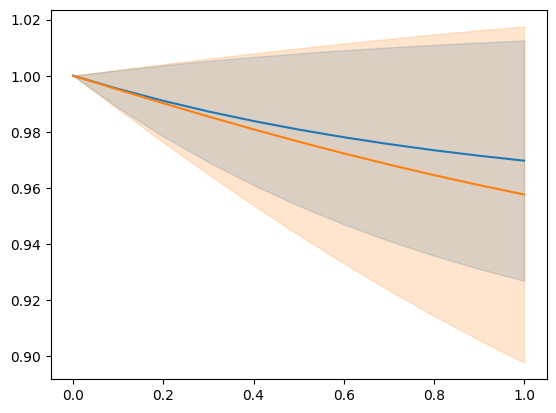

In [8]:
mc_parameters = pd.DataFrame(
    {
        1: {"k2": 1.0, "k3": 1.0},
        2: {"k2": 1.1, "k3": 1.2},
    }
).T


tc = mc.time_course(
    get_linear_chain_2v(),
    time_points=np.linspace(0, 1, 11),
    mc_parameters=mc_parameters,
)

fig, ax = plt.subplots()
plot.mc_line_mean_std(tc.concs, "x", ax=ax)
plot.mc_line_mean_std(tc.concs, "y", ax=ax)

### Protocol time series

100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


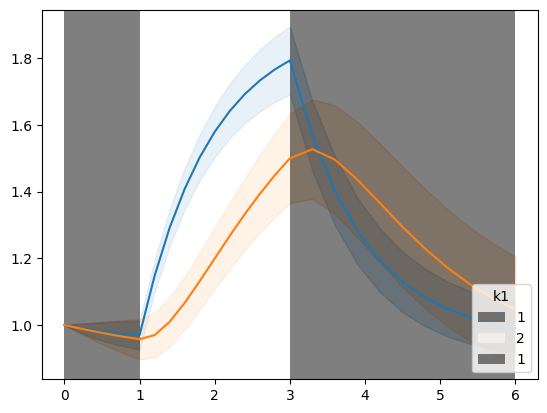

In [9]:
mc_parameters = pd.DataFrame(
    {
        1: {"k2": 1.0, "k3": 1.0},
        2: {"k2": 1.1, "k3": 1.2},
    }
).T


protocol = make_protocol(
    {
        1: {"k1": 1},
        2: {"k1": 2},
        3: {"k1": 1},
    }
)

tc = mc.time_course_over_protocol(
    get_linear_chain_2v(),
    time_points_per_step=10,
    protocol=protocol,
    mc_parameters=mc_parameters,
)
fig, ax = plt.subplots()
plot.mc_line_mean_std(tc.concs, "x", ax=ax)
plot.mc_line_mean_std(tc.concs, "y", ax=ax)
plot.shade_protocol(protocol["k1"], ax=ax)

### Metabolic control analysis

In [10]:
mc_parameters = pd.DataFrame(
    {
        1: {"k2": 1.0, "k3": 1.0},
        2: {"k2": 1.1, "k3": 1.2},
    }
).T

ce = mc.compound_elasticities(
    get_linear_chain_2v(),
    variables=["x", "y"],
    concs={"x": 1.0, "y": 1.0},
    mc_parameters=mc_parameters,
)
ce.head()

100%|██████████| 2/2 [00:00<00:00,  5.25it/s]


x    y
1 v1  0.0  0.0
  v2  1.0  0.0
  v3  0.0  1.0
2 v1  0.0  0.0
  v2  1.0  0.0

In [11]:
mc_parameters = pd.DataFrame(
    {
        1: {"k2": 1.0, "k3": 1.0},
        2: {"k2": 1.1, "k3": 1.2},
    }
).T

ce = mc.parameter_elasticities(
    get_linear_chain_2v(),
    parameters=["k1"],
    concs={"x": 1.0, "y": 1.0},
    mc_parameters=mc_parameters,
)
ce.head()

100%|██████████| 2/2 [00:00<00:00,  3.77it/s]


k1
1 v1  1.0
  v2  0.0
  v3  0.0
2 v1  1.0
  v2  0.0

In [12]:
mc_parameters = pd.DataFrame(
    {
        1: {"k2": 1.0, "k3": 1.0},
        2: {"k2": 1.1, "k3": 1.2},
    }
).T

crcs, frcs = mc.response_coefficients(
    get_linear_chain_2v(),
    ["k1", "k2"],
    mc_parameters=mc_parameters,
)
crcs.head()

100%|██████████| 2/2 [00:00<00:00,  4.39it/s]


x             y
1 k1  1.0  1.000000e+00
  k2 -1.0  0.000000e+00
2 k1  1.0  1.000000e+00
  k2 -1.0 -3.330669e-12

### Steady-state parameter scan

Vary **both** monte carlo parameters as well as systematically scan for other parameters

In [7]:
mcss = mc.parameter_scan_ss(
    get_linear_chain_2v(),
    parameters={"k1": np.linspace(0, 1, 3)},
    mc_parameters=pd.DataFrame(
        {
            1: {"k2": 1.0, "k3": 1.0},
            2: {"k2": 1.1, "k3": 1.2},
        }
    ).T,
)

mcss.concs.head()

100%|██████████| 2/2 [00:00<00:00,  5.69it/s]


x             y
  k1                             
1 0.0 -2.144953e-17 -3.839487e-16
  0.5  5.000000e-01  5.000000e-01
  1.0  1.000000e+00  1.000000e+00
2 0.0 -1.087796e-19 -1.333593e-18
  0.5  4.545455e-01  4.166667e-01